In [1]:
from prometheus_api_client import PrometheusConnect, MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime
import pandas as pd
import pendulum
from tinydb import TinyDB, Query
from os import getenv
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from entrypoint import load_gin
load_gin("ingest-kafka", test=False)
import greenflow.analysis as an
import qgridnext as qgrid

[WARNING]: failed to patch stdout/stderr for fork-safety: 'OutStream' object
has no attribute 'buffer'
[WARNING]: failed to reconfigure stdout/stderr with custom encoding error
handler: 'OutStream' object has no attribute 'reconfigure'


In [6]:
import greenflow.analysis as an
from entrypoint import load_gin

cutoff_begin = "2024-12-16T03:15:35.626996+01:00"
cutoff_end = pendulum.now().to_iso8601_string()

load_gin(exp_name="ingest-kafka", test=False)
df = an.full_analytical_pipeline_nocache(
    cutoff_begin=cutoff_begin,
    cutoff_end=cutoff_end,
    cluster="ovhnvme",
    type="proportionality",
)
# experiments = an.get_experiments()
# redpanda_kafka_data = an.filter_experiments(
#     experiments,
#     an.interest(cluster="ovhnvme", type="memImpact"),
#     cutoff_begin=cutoff_begin,
#     cutoff_end=cutoff_end,
# )
df = df[df["load"] != 0]
an.create_qgrid_widget(df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [3]:
# import dill
# dill.dump_session('montcalm_threshold.db')
# dill.load_session('montcalm_threshold.db')
# qgrid_widget = qgrid.show_grid(redpanda_kafka_data, show_toolbar=True)

enriched_data = an.enrich_dataframe(redpanda_kafka_data)
# qgrid_widget

NameError: name 'redpanda_kafka_data' is not defined

In [5]:
# if edit:
#   enriched_data = qgrid_widget.get_changed_df()

# The throughput gap should be negative
qgrid_widget = qgrid.show_grid(enriched_data, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

30.002198486328126 273.16362304687505


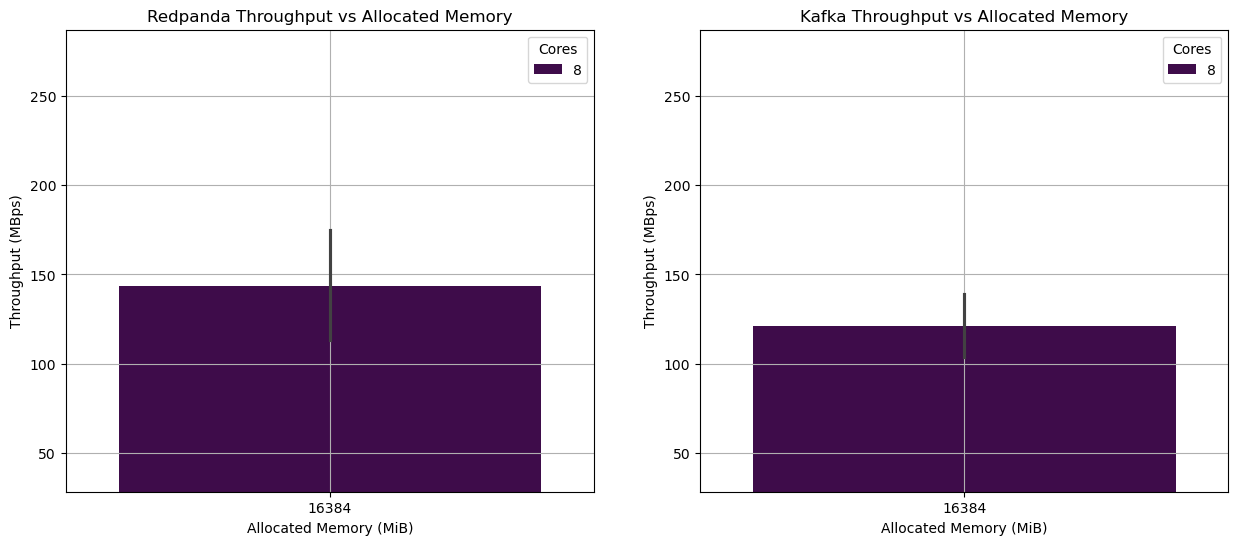

In [5]:
import seaborn as sns


redpanda_df = enriched_data[enriched_data["exp_name"] == "ingest-redpanda"]
kafka_df = enriched_data[enriched_data["exp_name"] == "ingest-kafka"]


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Convert memory to MiB for sorting
def convert_to_mib(mem_str):
    if 'Mi' in mem_str:
        return int(mem_str.replace('Mi', ''))
    elif 'Gi' in mem_str:
        return int(mem_str.replace('Gi', '')) * 1024

# Add a new column for memory in MiB
redpanda_df['broker_mem_mib'] = redpanda_df['broker_mem'].apply(convert_to_mib)
min_throughput = min(redpanda_df['throughput_MBps'].min(), kafka_df['throughput_MBps'].min())
max_throughput = max(redpanda_df['throughput_MBps'].max(), kafka_df['throughput_MBps'].max())

print(min_throughput, max_throughput)

kafka_df['broker_mem_mib'] = kafka_df['broker_mem'].apply(convert_to_mib)
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=redpanda_df, x='broker_mem_mib', y='throughput_MBps', hue='broker_cpu', palette='viridis')
# sns.pointplot(data=redpanda_df, x='broker_mem_mib', y='throughput_MBps', hue='broker_cpu')

plt.title('Redpanda Throughput vs Allocated Memory')
plt.xlabel('Allocated Memory (MiB)')
plt.ylabel('Throughput (MBps)')
plt.legend(title='Cores')
plt.ylim((min_throughput - 0.05 * min_throughput, max_throughput + 0.05 * max_throughput))
plt.grid(True)

plt.subplot(1, 2, 2)
# sns.scatterplot(data=kafka_df, x='broker_mem_mib', y='throughput_MBps', hue='broker_cpu', palette='viridis', alpha=0.7)
sns.barplot(data=kafka_df, x='broker_mem_mib', y='throughput_MBps', hue='broker_cpu', palette='viridis')
plt.title('Kafka Throughput vs Allocated Memory')
plt.xlabel('Allocated Memory (MiB)')
plt.ylabel('Throughput (MBps)')
plt.legend(title='Cores')
plt.ylim((min_throughput - 0.05 * min_throughput, max_throughput + 0.05 * max_throughput))
plt.grid(True)
plt.show()

In [6]:
import seaborn as sns

# Use seaborn's scatterplot with hue for differentiation
g = sns.FacetGrid(data, row="broker_cpu", hue="exp_name", height=5, aspect=1.5)
g.map(sns.scatterplot, "messageSize", "throughput_per_watt", alpha=0.7)
g.add_legend()
g.set_axis_labels("Message Size (bytes)", "Throughput per watt (MB/W)")
g.set_titles(col_template="CPU: {col_name}")
for ax in g.axes.flat:
    # Get the current broker_cpu value for this subplot
    cpu = ax.get_title().split('=')[1].strip()
    
    # Iterate over each experiment name
    for exp_name in data['exp_name'].unique():
        # Filter the dataframe for the current CPU and experiment
        subset = data[(data['broker_cpu'].astype(str) == cpu) & (data['exp_name'] == exp_name)]
        
        # Plot the mean and confidence interval
        sns.lineplot(
            data=subset,
            x='messageSize',
            y='throughput_per_watt',
            ax=ax,
            errorbar='sd',  # Use standard deviation for confidence interval
            estimator='mean',  # Plot the mean
            label=f'{exp_name} Mean',
            linewidth=2.5
        )


plt.show()


NameError: name 'data' is not defined

In [2]:
import matplotlib.pyplot as plt

# Function to create the graph for a specific system
def create_graph(data, system_name):
    # Filter data for the specific system
    system_data = data

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    cmap = plt.cm.RdYlGn

    # Create scatter plot for all points except the last point for each message size
    scatter = ax.scatter(
        system_data["messageSize"][:-1],
        system_data["observed_throughput"][:-1],
        c=system_data["throughput_gap_percentage"][:-1],
        cmap=cmap,
        s=50,
    )

    # Create scatter plot for the last point of each message size with a different marker style
    last_points = system_data.groupby("messageSize").first()
    ax.scatter(
        last_points.index,
        last_points["observed_throughput"],
        s=100,
        marker="o",
        linewidths=1,
    )

    for idx, row in last_points.iterrows():
        ax.annotate(f"{row['observed_throughput']:f}", (idx, row['observed_throughput']), 
                    textcoords="offset points", xytext=(20, 40), ha='center',
                    arrowprops=dict(arrowstyle="-", color='black', linewidth=0.5, shrinkA=0, shrinkB=0))

    # Sort the last points by messageSize
    last_points = last_points.sort_index()

    # Connect the last points with a line
    ax.plot(last_points.index, last_points["observed_throughput"], linestyle="-", color="black")

    # Fill the area below the line as "Safe"
    ax.fill_between(last_points.index, last_points["observed_throughput"], color="green", alpha=0.2, label="Safe")

    # Fill the area above the line as "Not safe"
    ax.fill_between(last_points.index, last_points["observed_throughput"], y2=ax.get_ylim()[1], color="red", alpha=0.2, label="Not safe")

    # Add color bar
    plt.colorbar(scatter, ax=ax, label="Throughput Gap (%)", extend="min")

    ax.set_title(f"Observed Throughput vs Message Size for {system_name}")
    ax.set_xlabel("Message Size (bytes)")
    ax.set_ylabel("Observed Throughput (messages/sec)")

    # Add legend
    ax.legend()

    plt.tight_layout()
    plt.show()

    return last_points


# Create graphs for Montcalm and Neowise
kafka_last_points = create_graph(data[data["exp_name"] == "ingest-kafka"], "Kafka")
redpanda_last_points = create_graph(data[data["exp_name"] == "ingest-redpanda"], "Redpanda")

# Create a new figure for comparing the safety lines
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the safety lines for Kafka and Redpanda
ax.plot(kafka_last_points.index, kafka_last_points["observed_throughput"], linestyle="-", color="blue", label="Kafka")
ax.plot(redpanda_last_points.index, redpanda_last_points["observed_throughput"], linestyle="-", color="red", label="Redpanda")

# Fill the region that can be handled by both Kafka and Redpanda
ax.fill_between(kafka_last_points.index, kafka_last_points["observed_throughput"], color="green", alpha=0.2, label="Handled by both")

# Fill the region that can be handled by Redpanda but not Kafka
ax.fill_between(kafka_last_points.index, kafka_last_points["observed_throughput"], redpanda_last_points["observed_throughput"], where=(redpanda_last_points["observed_throughput"] > kafka_last_points["observed_throughput"]), color="yellow", alpha=0.2, label="Handled by Redpanda only")

# Fill the region that cannot be handled by both
ax.fill_between(redpanda_last_points.index, redpanda_last_points["observed_throughput"], y2=ax.get_ylim()[1], color="red", alpha=0.2, label="Not handled by both")

ax.set_title("Safety Lines Comparison: Kafka vs Redpanda")
ax.set_xlabel("Message Size (bytes)")
ax.set_ylabel("Observed Throughput (messages/sec)")

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


NameError: name 'data' is not defined

In [ ]:
# Create a new figure for comparing the throughput
fig, ax = plt.subplots(figsize=(12, 8))

# Plot Kafka throughput
ax.plot(kafka_last_points.index, kafka_last_points["throughput_per_watt"], 
        linestyle="-", marker="o", color="blue", label="Kafka")

# Plot Redpanda throughput
ax.plot(redpanda_last_points.index, redpanda_last_points["throughput_mBps"], 
        linestyle="-", marker="o", color="red", label="Redpanda")

ax.set_title("Throughput vs Message Size for Kafka and Redpanda")
ax.set_xlabel("Message Size (bytes)")
ax.set_ylabel("Throughput (MB/s)")
# ax.set_xscale('log')  # Set x-axis to logarithmic scale
# ax.set_yscale('log')  # Set y-axis to logarithmic scale

# Add legend
ax.legend()

# Add grid
ax.grid(True, which="both", ls="-", alpha=0.2)

# Annotate data points
for data, color in [(kafka_last_points, "blue"), (redpanda_last_points, "red")]:
    for idx, row in data.iterrows():
        ax.annotate(f"{row['throughput_per_watt']:.2f}", 
                    (idx, row['throughput_per_watt']), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center',
                    color=color,
                    fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
data = enriched_data[enriched_data["throughput_gap_percentage"] >= -5]
def create_graph(data, system_name):
    # Filter data for the specific system
    system_data = data

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    cmap = plt.cm.RdYlGn

    # Create scatter plot for all points
    scatter = ax.scatter(
        system_data["messageSize"],
        system_data["load"],
        c=system_data["throughput_gap_percentage"],
        cmap=cmap,
        s=50,
    )

    # Find the maximum "safe" load for each message size
    # safe_data = system_data[system_data["throughput_gap_percentage"] >= -5]
    # max_safe_points = .groupby("messageSize").agg({"load": "max"}).reset_index()
    max_safe_points = system_data

    # Create scatter plot for the max safe points with a different marker style
    ax.scatter(
        max_safe_points["messageSize"],
        max_safe_points["load"],
        s=100,
        marker="o",
        linewidths=1,
        color="black",
    )

    for idx, row in max_safe_points.iterrows():
        ax.annotate(f"{row['load']:d}", (row['messageSize'], row['load']), 
                    textcoords="offset points", xytext=(20, 40), ha='center',
                    arrowprops=dict(arrowstyle="-", color='black', linewidth=0.5, shrinkA=0, shrinkB=0))

    # Sort the max safe points by messageSize
    max_safe_points = max_safe_points.sort_values("messageSize")

    # Connect the max safe points with a line
    ax.plot(max_safe_points["messageSize"], max_safe_points["load"], linestyle="-", color="black")

    # Fill the area below the line as "Safe"
    ax.fill_between(max_safe_points["messageSize"], max_safe_points["load"], color="green", alpha=0.2, label="Safe")

    # Fill the area above the line as "Not safe"
    ax.fill_between(max_safe_points["messageSize"], max_safe_points["load"], y2=ax.get_ylim()[1], color="red", alpha=0.2, label="Not safe")

    # Add color bar
    plt.colorbar(scatter, ax=ax, label="Throughput Gap (%)", extend="min")

    ax.set_title(f"Load vs Message Size for {system_name}")
    ax.set_xlabel("Message Size (bytes)")
    ax.set_ylabel("Load (messages/sec)")

    # Add legend
    ax.legend()

    plt.tight_layout()
    plt.show()

    return max_safe_points

# Create graphs for Kafka and Redpanda
kafka_max_safe_points = create_graph(data[data["exp_name"] == "ingest-kafka"], "Kafka")
redpanda_max_safe_points = create_graph(data[data["exp_name"] == "ingest-redpanda"], "Redpanda")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = enriched_data
def plot_power_efficiency(data, system_name):
    # Filter data for the specific system and safe points
    safe_data = data[(data["exp_name"] == f"ingest-{system_name.lower()}") & (data["throughput_gap_percentage"] >= -5)].copy()

    # Calculate power efficiency
    safe_data.loc[:, 'power_efficiency_MBps'] = safe_data['throughput_MBps'] / safe_data['average_power']
    safe_data.loc[:, 'power_efficiency_records'] = safe_data['observed_throughput'] / safe_data['average_power']

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot for throughput in MB/s
    scatter1 = ax1.scatter(
        safe_data["messageSize"],
        safe_data["load"],
        c=safe_data["power_efficiency_MBps"],
        cmap="viridis",
        s=50,
    )

    ax1.set_title(f"Power Efficiency (MB/s) for {system_name}")
    ax1.set_xlabel("Message Size (bytes)")
    ax1.set_ylabel("Load (messages/sec)")
    # ax1.set_xscale('log')
    ax1.set_yscale('log')

    # Add color bar
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label("Power Efficiency (MB/s per Watt)")

    # Plot for observed throughput in records/sec
    scatter2 = ax2.scatter(
        safe_data["messageSize"],
        safe_data["load"],
        c=safe_data["power_efficiency_records"],
        cmap="viridis",
        s=50,
    )

    ax2.set_title(f"Power Efficiency (records/sec) for {system_name}")
    ax2.set_xlabel("Message Size (bytes)")
    ax2.set_ylabel("Load (messages/sec)")
    # ax2.set_xscale('log')
    ax2.set_yscale('log')

    # Add color bar
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label("Power Efficiency (records/sec per Watt)")

    plt.tight_layout()
    plt.show()

# Create power efficiency plots for Kafka and Redpanda
plot_power_efficiency(data, "Kafka")
plot_power_efficiency(data, "Redpanda")

# The rest of your code for creating the safety line comparison graph remains the same
